In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /home/hchang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv("../../data/news/allnews.csv")
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 38053


In [ ]:
data.head()

,신문사,분류,제목,본문,날짜 및 시간
0,프레시안,경제,뉴라운드 협상 이제부터다 - WTO 국민연대 장원석 집행위원장의 협상 참관기,지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구(WTO) 각료...,['2001-11-21 09:53:00']
1,프레시안,세계,"미, 이슬람권 대상 방송국 설립 추진 - 본격 선전전 나서",미 정부가 아랍권 여론 장악을 위해 5억달러를 들여 위성방송국 설립을 추진중인 ...,['2001-11-21 09:53:00']
2,프레시안,정치,개혁신당 운동 젊은 의원들이 밀어붙여라 - 이부영 한나라당 부총재 인터뷰,한나라당 이부영 부총재는 19일 프레시안과 인터뷰를 갖고 개혁신당 운동에 대해 ...,['2001-11-21 09:53:00']
3,프레시안,세계,잊혀진 나라 '아프간' <6ㆍ끝> - 누가 이 전쟁을 멈출 것인가,아프간의 기아 참상을 영화로 찍기 위해 방글라데시 유엔 대표인 카말 후세인 박사...,['2001-11-20 10:01:00']
4,프레시안,세계,"미국, 고문 합법화. 비밀재판 추진 - ""미국이외는 야만이라는 미국의 야만적 사고""",“테러범들에 대한 고문을 합법화해야 한다.”\n “테러범들은 비밀리에 항공모함...,['2001-11-20 10:01:00']


In [ ]:
data = data[['본문','제목']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,본문,제목
25479,현대의 경영개선 계획 전문\n\n현대는 지난 27일 주채권은행인 외환은행으로부터 경...,[일반] 현대 경영개선계획(전문종합)
33094,전동공구 제조회사 블랙앤드데커( www. blackanddecker)가 건전지식 스...,"[새상품] 블랙앤드데커, 건전지로 작동하는 스크류드라이버"
8801,(서울=연합뉴스) 김종현기자= 이용근(李容根) 금융감독위원장은 30일 일각에서는 한...,`한투.대투 합병 없다'<이 금감위원장>
7293,(서울=연합뉴스) 정준영기자= 대한상공회의소는 법정근로시간 단축이 경제위기를 몰고 ...,"상의, 법정근로시간 단축 강력 반대"
13504,(베이징=연합뉴스) 중국은 한국전쟁 발발 50년이 지난 지금도 한국전쟁에서 수많은 ...,"<중국, 한국전쟁 개입에 아직도 자부심>"
7042,(부산=연합뉴스)김상현기자 = 올들어 북양 명태와 원양 오징어가 어획부진과 함께 국...,"북양명태.원양오징어, 어획부진.소비위축"
30548,'우리 주식시장은 축구와 마찬가지로 '허리'가 약한 게 문제.'\n\n2일 증권가에...,"[증권]동부 ""증시, 미국 비해 '미드필더' 취약"""
21549,(광주=연합뉴스) 여운창기자 = 감기증세로 병원 응급실에서 치료를 받은 환자가사망해...,"감기증세로 치료받던 환자, 병원에서 사망"
7739,(워싱턴=연합뉴스) 미국 하원은 23일 베트남전에서 미 중앙정보국(CIA)에 고용돼...,미국내 흐몽족 시민권 부여법안 하원 통과
26539,ＬＧ화학(사장 성재갑)은 기존 제품에 비해 부작용을 크게 줄인 새로운 고혈압 치료제...,"LG화학, 고혈압 치료제 '자니딥' 판매"


In [ ]:
print('본문 열에서 중복을 배제한 유일한 샘플의 수 :', data['본문'].nunique())
print('제목 열에서 중복을 배제한 유일한 샘플의 수 :', data['제목'].nunique())

본문 열에서 중복을 배제한 유일한 샘플의 수 : 35940
제목 열에서 중복을 배제한 유일한 샘플의 수 : 36039


In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['본문'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 35941


In [ ]:
print(data.isnull().sum())

본문    1
제목    1
dtype: int64


In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 35939


In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
import os
os.listdir('/home/hchang/nltk_data/corpora/stopwords')

['slovene',
 'italian',
 'romanian',
 'english',
 'portuguese',
 'azerbaijani',
 'german',
 'hungarian',
 'swedish',
 'russian',
 'finnish',
 'indonesian',
 'danish',
 'README',
 'dutch',
 'tajik',
 'french',
 'norwegian',
 'nepali',
 'bengali',
 'spanish',
 'greek',
 'arabic',
 'kazakh',
 'turkish']

In [ ]:
# print('불용어 개수 :', len(stopwords.words('ko') ))
# print(stopwords.words('english'))

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    # sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    # sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    # sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    # sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z가-힣ㄱ-ㅎ0-9]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    # sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub("\s+", ' ', sentence)
    # 불용어 제거 (Text)
    # if remove_stopwords:
    #     tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    # else:
    #     tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return sentence
print('=3')

=3


In [ ]:
temp_text = '오늘도 끝내주게 바쁜 하루였다. ... [중략] 어디서부터 고쳐볼까?'
temp_summary = '오늘도 바빴다.'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  오늘도 끝내주게 바쁜 하루였다 중략 어디서부터 고쳐볼까 
summary: 오늘도 바빴다 


In [ ]:
from tqdm import tqdm

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['본문']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 35939/35939 [00:04<00:00, 8289.81it/s] 

Text 전처리 후 결과:  [' 지난 11월 9일부터 14일까지 카타르 도하에서 열린 세계무역기구 wto 각료회의에서 우리의 관심 사항은 시장접근 국내보조 비교역적 관심사항 ntc 등이었다 특히 농업 부문 협상의 성패는 그야말로 농업이 사느냐 죽느냐의 관건이라 해도 과언이 아니었다 일례를 들어 현재 농축산물의 평균관세는 60 수준인데 수출강대국의 요구대로 철폐 내지 대폭 감축한다면 우리의 가격경쟁력은 50 60 떨어지게 되기 때문이다 이를 극복하기 위해서는 기술 경영 유통 등의 구조혁신에 의하여 생산비를 50 60 이상 줄여야 하는데 이에는 20년 내지 30년 이상 소요된다 이처럼 순간의 협상이 엄청난 결과를 가져오는 것이다 그런데도 냉혹한 국제환경 속에서 우리의 대응책은 골리앗에 대항하여 싸우는 다윗처럼 비쳐졌다 그러므로 정부 혼자만의 힘으로는 안 되고 국민적 힘과 지혜를 모아 함께 대응해야 하는 사안이었다 이러한 처지는 강대국도 마찬가지이기는 하다 유럽연합 eu 은 농민단체의 요구와 시위를 교묘하게 이용했다 일본도 의원들과 전국농협중앙회 등 ngo의 지원을 받아가며 세계무역기구 사무국 실력자들을 만나 국내여론을 전하고 입장을 표명하는 등 동분서주하였다 제3세계에서는 정부의 협상력을 보완하기 위해 민간전문가들을 정부대표로 위장시켜 내세우기도 했다 미국마저 협상대표들은 국내 압력단체들을 설득할 수 있는 용어의 선택에 신경 쓰면서 우리나라 등 ntc 농업의 비교역적 관심사항 그룹 대표들에게 양해를 구하는 등 온갖 수단과 방법을 동원하는 것을 전해 들으면서 초강대국 미국 역시 다자간 협상장인 wto 협상에서는 한계가 있다는 것을 느꼈다 여하튼 wto 협상은 정부 의회 ngo들이 때로는 비판하고 때로는 공동대응하면서 국가와 국민 계층의 이익을 관철시키기 위해 추호의 허술함도 보여서는 안 되는 전쟁과도 같은 것이었다 wto 협상 농업부문의 3대 목표 당초에 농업과 관련해서 우리 ngo와 정부가 관철시키려 한 것은 다음의 세 가지였다 첫째 wto가 마련한 초안에 의하

In [ ]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['제목']):
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

100%|██████████| 35939/35939 [00:00<00:00, 177136.71it/s]

Summary 전처리 후 결과:  ['뉴라운드 협상 이제부터다 wto 국민연대 장원석 집행위원장의 협상 참관기', '미 이슬람권 대상 방송국 설립 추진 본격 선전전 나서', '개혁신당 운동 젊은 의원들이 밀어붙여라 이부영 한나라당 부총재 인터뷰', '잊혀진 나라 아프간 6 끝 누가 이 전쟁을 멈출 것인가', '미국 고문 합법화 비밀재판 추진 미국이외는 야만이라는 미국의 야만적 사고']


In [ ]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [ ]:
data.isnull().sum()

본문         0
제목         0
Text       0
Summary    0
dtype: int64

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 35939


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 5332
텍스트의 평균 길이 : 211.21063468655223
요약의 최소 길이 : 0
요약의 최대 길이 : 18
요약의 평균 길이 : 5.328974094994296


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


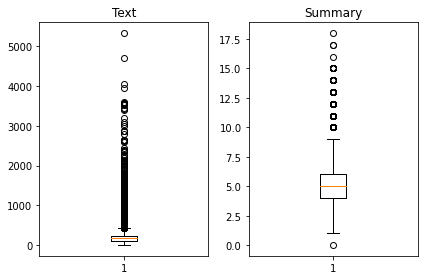

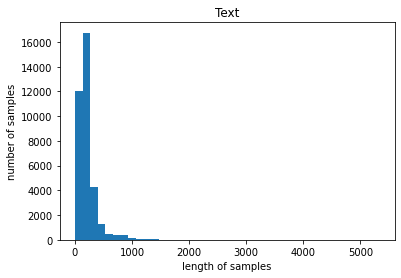

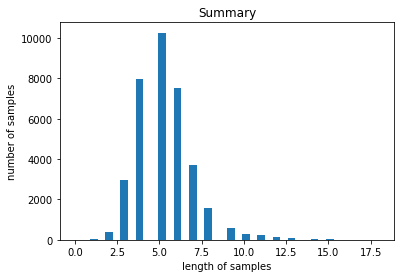

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 600
summary_max_len = 15
print('=3')

=3


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [ ]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 800 이하인 샘플의 비율: 0.9803277776231949
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9998887002977267


In [ ]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 35231


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 800
텍스트의 평균 길이 : 192.80148164968352
요약의 최소 길이 : 1
요약의 최대 길이 : 15
요약의 평균 길이 : 5.270017881978939


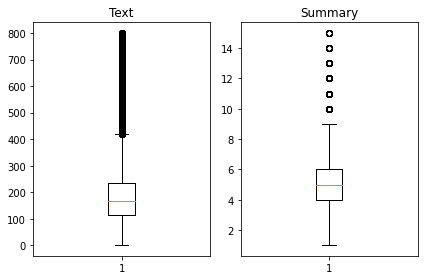

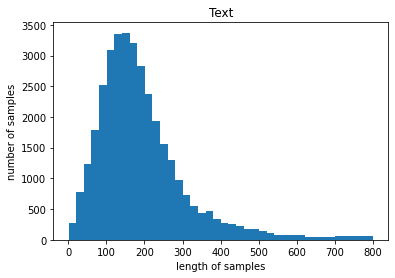

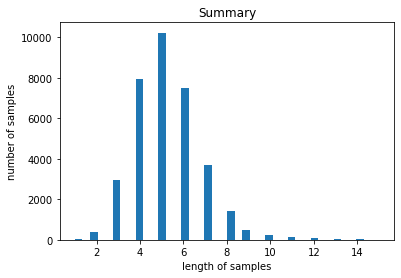

In [ ]:
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
data[data['Text'].apply(lambda x: len(x.split()) == 15)]

,본문,제목,Text,Summary
2192,"13일 열린 정기총회에서 임기 2년의 회장으로 재선출됐다.또 명예회장에 김성환씨,부...",[동정] 이홍우 한국시사만화가회회장,13일 열린 정기총회에서 임기 2년의 회장으로 재선출됐다 또 명예회장에 김성환씨 부...,동정 이홍우 한국시사만화가회회장
25165,거래소 투자자별 순매수 규모\n\n외국인 -3억원\n\n기관 -526억원\n\n개인...,[외국인/기관/개인동향] 거래소 외인 3억 순매도-30일 10:00,거래소 투자자별 순매수 규모 외국인 3억원 기관 526억원 개인 333억원 프로그램...,외국인 기관 개인동향 거래소 외인 3억 순매도 30일 10 00
25191,거래소 투자자별 순매수 규모\n\n외국인 118억원\n\n기관 -791억원\n\n개...,[외국인/기관/개인동향] 거래소 외국인 118억원 순매수-30일 오전 11:05,거래소 투자자별 순매수 규모 외국인 118억원 기관 791억원 개인 463억원 프로...,외국인 기관 개인동향 거래소 외국인 118억원 순매수 30일 오전 11 05
25435,김재수 현대그룹 구조조정위원장은 31일 오후 2시 계동사옥 15층 대회의실에서 유동...,"[일반] 현대, 오후 2시 최종 자구책 발표(속보1)",김재수 현대그룹 구조조정위원장은 31일 오후 2시 계동사옥 15층 대회의실에서 유동...,일반 현대 오후 2시 최종 자구책 발표 속보1
25452,김재수 현대그룹 구조조정위원장은 31일 오후 2시 계동사옥 15층 대회의실에서 유동...,"[일반] 현대, 오후 2시 최종 자구책 발표(1보)",김재수 현대그룹 구조조정위원장은 31일 오후 2시 계동사옥 15층 대회의실에서 유동...,일반 현대 오후 2시 최종 자구책 발표 1보
25562,거래소 투자자별 순매수 규모\n\n외국인 171억원\n\n기관 402억원\n\n개인...,[외국인/기관/개인동향] 거래소 기관 402억원 순매수-1일 10:18,거래소 투자자별 순매수 규모 외국인 171억원 기관 402억원 개인 733억원 프로...,외국인 기관 개인동향 거래소 기관 402억원 순매수 1일 10 18
26007,코스닥 투자주체별 매매동향\n\n외국인 +53억원\n\n기관 -98억원\n\n투신 ...,[외국인/기관/개인동향] 코스닥 외인 53억 순매수-5일 10:33,코스닥 투자주체별 매매동향 외국인 53억원 기관 98억원 투신 74억원 개인 5억원...,외국인 기관 개인동향 코스닥 외인 53억 순매수 5일 10 33
26027,코스닥 투자주체별 매매동향\n\n외국인 +70억원\n\n기관 -124억원\n\n투신...,[외국인/기관/개인동향] 코스닥 기관 124억 순매도-5일 11:38,코스닥 투자주체별 매매동향 외국인 70억원 기관 124억원 투신 113억원 개인 3...,외국인 기관 개인동향 코스닥 기관 124억 순매도 5일 11 38
26056,"13일 전북 전주시 완산구 태평1동 12-22 자택, 발인 15일 오전 9시40분....",[부음] 眞成정사씨(진각종 향수심인당 주교) 모친상,13일 전북 전주시 완산구 태평1동 12 22 자택 발인 15일 오전 9시40분 0...,부음 정사씨 진각종 향수심인당 주교 모친상
26076,"@신진피혁공업·두산포장＝각각 유니켐, 두산테크팩으로 변경상장.\n\n@송원칼라·현대...",[공시] 신진피혁공업/두산포장/송원칼라/현대건설,신진피혁공업 두산포장 각각 유니켐 두산테크팩으로 변경상장 송원칼라 현대건설 대표이...,공시 신진피혁공업 두산포장 송원칼라 현대건설


In [ ]:
data = data[data['Text'].apply(lambda x: len(x.split()) >= 11)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 35175


In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,본문,제목,Text,Summary,decoder_input,decoder_target
1,미 정부가 아랍권 여론 장악을 위해 5억달러를 들여 위성방송국 설립을 추진중인 ...,"미, 이슬람권 대상 방송국 설립 추진 - 본격 선전전 나서",미 정부가 아랍권 여론 장악을 위해 5억달러를 들여 위성방송국 설립을 추진중인 것...,미 이슬람권 대상 방송국 설립 추진 본격 선전전 나서,sostoken 미 이슬람권 대상 방송국 설립 추진 본격 선전전 나서,미 이슬람권 대상 방송국 설립 추진 본격 선전전 나서 eostoken
5,"기업들의 경쟁적 중국행 러시로 일본, 대만, 싱가포르, 홍콩 등 중국 주변국의 ‘산...","중국發 '산업공동화' 도래 - 한국기업 ""국내투자 NO, 중국투자 YES""",기업들의 경쟁적 중국행 러시로 일본 대만 싱가포르 홍콩 등 중국 주변국의 산업공동화...,중국 산업공동화 도래 한국기업 국내투자 no 중국투자 yes,sostoken 중국 산업공동화 도래 한국기업 국내투자 no 중국투자 yes,중국 산업공동화 도래 한국기업 국내투자 no 중국투자 yes eostoken
6,영국의 경제전문지 파이낸셜타임스가 18일(현지시간) 우리나라의 차세대전투기(FX...,"한국 국방부, 미 보잉사 위해 로비? - 파이낸셜타임스 보도",영국의 경제전문지 파이낸셜타임스가 18일 현지시간 우리나라의 차세대전투기 fx 선...,한국 국방부 미 보잉사 위해 로비 파이낸셜타임스 보도,sostoken 한국 국방부 미 보잉사 위해 로비 파이낸셜타임스 보도,한국 국방부 미 보잉사 위해 로비 파이낸셜타임스 보도 eostoken
7,다음은 미 시애틀에서 발행되는 시애틀 포스트-인텔리젠서의 18일자 사설 ‘석유와...,미국의 석유의존이 9.11 불렀다 - 평화ㆍ생태보전 원한다면 석유의존 줄여라,다음은 미 시애틀에서 발행되는 시애틀 포스트 인텔리젠서의 18일자 사설 석유와 전...,미국의 석유의존이 9 11 불렀다 평화 생태보전 원한다면 석유의존 줄여라,sostoken 미국의 석유의존이 9 11 불렀다 평화 생태보전 원한다면 석유의존 줄여라,미국의 석유의존이 9 11 불렀다 평화 생태보전 원한다면 석유의존 줄여라 eostoken
9,"미국이 지난주말 한미연례안보협의회(SCM)에서 우리 정부에 F15-K 강매, 아...","미, F-15 전투기 구매 요구 - 아프간 전투병 파병ㆍ주한미군 분담금 증액도",미국이 지난주말 한미연례안보협의회 scm 에서 우리 정부에 f15 k 강매 아프가...,미 f 15 전투기 구매 요구 아프간 전투병 파병 주한미군 분담금 증액도,sostoken 미 f 15 전투기 구매 요구 아프간 전투병 파병 주한미군 분담금 증액도,미 f 15 전투기 구매 요구 아프간 전투병 파병 주한미군 분담금 증액도 eostoken


In [ ]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5851 24475 12570 ... 31126 28173 34909]


In [ ]:
what = np.arange(50)
what

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [ ]:
encoder_input[[3,2,1,3]]

array([' 다음은 미 시애틀에서 발행되는 시애틀 포스트 인텔리젠서의 18일자 사설 석유와 전쟁과의 연관을 아는가 를 번역한 것이다 이 사설은 중동지역의 평화 나아가 지구생태계의 보전을 위해서는 미국경제의 과도한 석유 의존을 줄여야 한다고 강조하고 있다 미 테러전쟁은 오사마 빈 라덴 등 테러리스트의 제거를 목표로 하고 있지만 그 뿌리에는 중동지역의 석유자원에 대한 미국의 집요한 집착이 있다 석유자원의 확보를 위해 미국은 사우디 아라비아 등 전제정권을 비호하고 있으며 이 때문에 아랍인들의 반미감정은 갈수록 높아가고 있다 지구상의 석유는 이르면 40년내에 바닥이 난다고 한다 따라서 이번 전쟁은 미국과 아랍권의 정치 군사적 갈등일 뿐만 아니라 유한한 자원을 둘러싼 자원쟁탈전의 측면도 보여 주고 있는 것이다 이번 전쟁의 장기적 생태적 의미를 짚어 보는 의미에서 이 글을 게재한다 편집자 미국의 테러전쟁과 미 국민의 내연기관에의 의존은 직접적이고도 불가피한 연관관계가 있다 석유가 필요없었다면 미국은 결코 중동문제에 그토록 과도하고 또 위험스럼게 개입을 하지 않았을 것이다 그럼에도 불구하고 미 의회는 이처럼 값비싼 희생을 요구하는 석유와 전쟁과의 연관에 애써 눈을 감고 있다 지금이야말로 아프가니스탄에 무차별 융단폭격이 가해지고 우리의 자식들이 외국의 전쟁터에서 싸늘한 시체가 돌아오는 지금이야말로 석유에의 과도한 의존을 줄일 수 있는 보다 합리적이고 장기적인 에너지대책의 기초를 세울 수 있는 절호의 기회다 그러나 우유부단한 연방 의원들은 다시 한번 이 도전으로부터 꽁무니를 빼고 있다 미 의회는 이번 회기에도 광범위한 에너지정책의 입안을 포기했다 이는 중대한 직무유기가 아닐 수 없다 너무도 오랫동안 미국은 탐욕스럽게 기름을 잡아먹는 내연기관에 석유를 채워주는 것이 에너지 안보의 전부라고 생각해 왔다 이는 정치적으로 군사적으로 그리고 생태적으로 절대 오래 지속될 수 없다 석유 확보를 위해 미국은 너무도 쉽게 옳지 않은 야합을 해 왔다 이같은 야합은 특히 중동지역에서 두드러진

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 7035


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 28140
훈련 레이블의 개수 : 28140
테스트 데이터의 개수 : 7035
테스트 레이블의 개수 : 7035


In [ ]:
tokenizer = Tokenizer() # 토크나이저 정의
tokenizer.fit_on_texts(hi := encoder_input_train+decoder_input_train +['eostoken eostoken eostoken eostoken eostoken eostoken eostoken eostoken eostoken eostoken']) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 779195
등장 빈도가 2번 이하인 희귀 단어의 수: 605582
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 173613
단어 집합에서 희귀 단어의 비율: 77.71892786786363
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.137487308932252


In [ ]:
src_vocab = 180000
tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 180,000으로 제한
tokenizer.fit_on_texts(hi) # 단어 집합 재생성
print('=3')

=3


In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train_tenser = tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test_tenser = tokenizer.texts_to_sequences(encoder_input_test)
decoder_input_train_tenser = tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_test_tenser = tokenizer.texts_to_sequences(decoder_input_test)


# 잘 진행되었는지 샘플 출력
print(encoder_input_train_tenser[:3])

[[54475, 21101, 29, 30, 66765, 75455, 31, 7044, 5683, 420, 2738, 4914, 75456, 59865, 56, 1911, 268, 173614, 66766, 28806, 1312, 8, 1053, 84, 357, 1927, 2787, 3467, 10346, 27588, 43, 35307, 712, 352, 4, 154, 45893, 45894, 54476, 75457, 35307, 45895, 81, 1630, 1581, 667, 129164, 103822, 42612, 7783, 16743, 103823, 1128, 91, 33435, 1198, 129165, 2595, 9, 18682, 101, 784, 229, 2, 9687, 190, 43, 49777, 1701, 21840, 31676, 11350, 10688, 103824, 75455, 1328, 3168, 23480, 222, 66767, 4084, 173615, 14161, 173616, 2787, 33436, 173617, 8599, 103825, 54477, 6, 822, 129166, 66768, 21102, 21840, 30177, 173618, 3467, 317, 4593, 34, 3089, 9242, 66767, 161, 25369, 6950, 68, 4021, 745, 812, 308, 6503, 4, 54478, 16302, 13840, 291, 1158, 4, 21103, 54479, 1666, 8737, 115, 45894, 2583, 272, 4247, 4021, 9687, 45894, 5127, 39, 2081, 812, 67, 169, 535, 45, 230, 103826, 212, 8, 2716, 32, 177, 84, 42613, 18183, 56, 30178, 20431, 103827, 54, 27589, 21840, 4914, 104, 2182, 6123, 25370, 129167, 699, 49778, 30, 444,

In [ ]:
decoder_target_train_tenser = tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test_tenser = tokenizer.texts_to_sequences(decoder_target_test)


In [ ]:
# tar_tokenizer = Tokenizer()
# tar_tokenizer.fit_on_texts(decoder_input_train)
# print('=3')

In [ ]:
# threshold = 3
# total_cnt = len(tar_tokenizer.word_index) # 단어의 수
# rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
# total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
# rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# for key, value in tar_tokenizer.word_counts.items():
#     total_freq = total_freq + value

#     # 단어의 등장 빈도수가 threshold보다 작으면
#     if(value < threshold):
#         rare_cnt = rare_cnt + 1
#         rare_freq = rare_freq + value

# print('단어 집합(vocabulary)의 크기 :', total_cnt)
# print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
# print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
# print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
# print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# set(tar_tokenizer.index_word.values()) - set(src_tokenizer.index_word.values())

In [ ]:
# tar_vocab = 10000
# tar_tokenizer = Tokenizer(num_words=tar_vocab) 
# tar_tokenizer.fit_on_texts(decoder_input_train)
# tar_tokenizer.fit_on_texts(decoder_target_train)

# # 텍스트 시퀀스를 정수 시퀀스로 변환
# decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
# decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
# decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
# decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# # 잘 변환되었는지 확인
# print('input')
# print('input ',decoder_input_train[:5])
# print('target')
# print('decoder ',decoder_target_train[:5])

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 28140
훈련 레이블의 개수 : 28140
테스트 데이터의 개수 : 7035
테스트 레이블의 개수 : 7035


In [ ]:
encoder_input_train = pad_sequences(encoder_input_train_tenser, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test_tenser, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train_tenser, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train_tenser, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test_tenser, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test_tenser, maxlen=summary_max_len, padding='post')
print('=3')

=3


In [ ]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(False)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

2022-05-24 15:43:16.515160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:16.545192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:16.545361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 15:43:16.545838: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(src_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(src_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 128)     23040000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 800, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(src_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 128)     23040000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 800, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=32, callbacks=[es], epochs=50)

Epoch 1/50


2022-05-24 15:43:22.214333: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6989807616 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-05-24 15:43:23.272932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


880/880 [==============================] - ETA: 0s - loss: 3.1687

2022-05-24 15:46:54.466574: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6989807616 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


880/880 [==============================] - 235s 260ms/step - loss: 3.1687 - val_loss: 2.8020
Epoch 2/50
880/880 [==============================] - 229s 261ms/step - loss: 2.9367 - val_loss: 2.7318
Epoch 3/50
880/880 [==============================] - 643s 731ms/step - loss: 2.8712 - val_loss: 2.6832
Epoch 4/50
 52/880 [>.............................] - ETA: 15:25 - loss: 2.7459

KeyboardInterrupt: 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f9c52fd3280>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


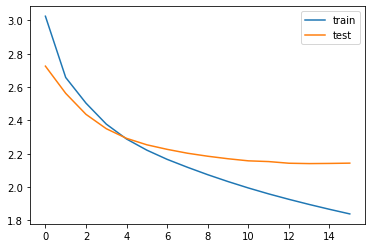

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bought iams kitten formula cheapest pet store kitten likes give diarrhea anything smell room much qualifies good kitten food book 
실제 요약 : kitten likes it 
예측 요약 :  not for my dog


원문 : got paid complaints buying food storage light easily stored perfect 
실제 요약 : as good as advertised 
예측 요약 :  great product


원문 : like using various types sauce foods tacos taco salads hamburgers etc first time used chipotle sauce loved smoking flavor perfect tacos fixed daughter tried liked well thick enough thick something ate hands flavor good sauce hot like taste basically good middle road sauce far heat factor providing great taste anyone wants something little different 
실제 요약 : my new favorite sauce 
예측 요약 :  great flavor


원문 : recently received one bars voxbox review purposes really quite enjoyed banana person like almonds figured would test glad would picked box grocery store since tried one purchased three boxes prefer microwave seconds since bar tastes better heated also bit crunchy ov

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [ ]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [ ]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [ ]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data.sample(10)

,headlines,text
26407,Pumps in Thai cave failed just after last boy ...,The water pumps draining the flooded cave in T...
47358,Shoaib Akhtar named brand ambassador of Pak Cr...,Former Pakistani fast bowler Shoaib Akhtar has...
35085,2 wickets in 2 balls happen twice in the same ...,"During the MI-RCB IPL match on Tuesday, two wi..."
14139,WhatsApp sets up system to store payments data...,Facebook-owned messaging service WhatsApp has ...
22052,Bajaj Electricals MD Anant Bajaj passes away a...,The Managing Director (MD) of Bajaj Electrical...
42296,Russia supplying arms to the Taliban: US,"The Commander of US forces in Afghanistan, Gen..."
62012,Bitcoin not to be used for payments for now: R...,Executive Director of Reserve Bank of India S ...
27758,Instagram may let users ask questions in Stories,Facebook-owned photo-sharing app Instagram is ...
45404,Who are the nominees for Best Actor at Oscars ...,Denzel Washington is among the nominees for th...
18323,BJP govt is India's most non-performing asset:...,"Ahead of the release of his new book, senior C..."
